# **Description synthétique du projet et de ses objectifs**


- L’objectif de ce projet final est de produire un modèle de prévision des séries temporelles, résultant des
expérimentations faites avec des méthodes statistiques et des méthodes ML de régression.

- Variable cible : Prédiction de la température (variable numérique continue) dans la ville choisie pour une journée avec un pas de temps de 3h : 00h, 03h, 06h, …, 21h.

- Méthodologie :   

1. Récupérez les valeurs de température dans la ville de votre choix pour une période de 4 ans, du
01/01/2020 00h au 31/12/2023 23h. Pensez à sélectionner le fuseau horaire correspondant à laville choisie. L’acquisition des données doit être faite avec un code en python.
2. Produisez une nouvelle série temporelle de façon suivante : la valeur à 00h sera la moyenne des
valeurs à 00h, 01h et 02h ; la valeur à 03h – la moyenne des valeurs à 03h, 04h et 05h ; et ainsi
de suite. Le pas de temps de la nouvelle série est de 3h. Utilisez la série transformée dans les
expérimentations.
3. Effectuez l’analyse des composantes de la série temporelle.
4. Implémentez et documentez les expérimentations avec les méthodes statistiques : ARIMA,
SARIMA et SARIMAX. Pour SARIMAX, choisissez une variable supplémentaire dans la même API.
Faites le tuning des hyperparamètres sur la grille.
5. Implémentez et documentez les expérimentations avec les méthodes ML de régression. Testez
les différentes variables explicatives : variables retardées (lag), variables construites à partir de
valeurs agrégées, variables exogènes (vous pouvez utiliser la même variable que vous aurez
choisie pour SARIMAX).
6. Effectuez l’analyse des résidus et documentez les résultats.

# Chargement des données avec l'API

In [ ]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.6 MB/s eta 0:00:00


In [ ]:
pip install statsmodels

In [ ]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.graphics.tsaplots as tsaplots

In [ ]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 6.816667,
	"longitude": -5.283333,
	"start_date": "2020-01-01",
	"end_date": "2023-12-31",
	"hourly": ["temperature_2m", "relative_humidity_2m"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m

hourly_dataframe = pd.DataFrame(data = hourly_data)
# Exporter le DataFrame en CSV avec l'index

hourly_dataframe.to_csv('hourly_data_2iemeVariable1.csv')

print(hourly_dataframe)

Coordinates 6.783831596374512°N -5.303009033203125°E
Elevation 194.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                           date  temperature_2m  relative_humidity_2m
0     2020-01-01 00:00:00+00:00       22.206501             80.577911
1     2020-01-01 01:00:00+00:00       21.956501             90.647461
2     2020-01-01 02:00:00+00:00       20.756500             93.716896
3     2020-01-01 03:00:00+00:00       21.456501             88.942535
4     2020-01-01 04:00:00+00:00       20.806499             95.477371
...                         ...             ...                   ...
35059 2023-12-31 19:00:00+00:00       27.156500             57.008179
35060 2023-12-31 20:00:00+00:00       25.556499             58.820053
35061 2023-12-31 21:00:00+00:00       25.506500             51.752068
35062 2023-12-31 22:00:00+00:00       26.756500             36.147060
35063 2023-12-31 23:00:00+00:00       24.356501             48.998436

[35064 rows x 3 columns]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/hourly_data_2iemeVariable.csv')
datacopy = data.copy()
datacopy.head()

,Unnamed: 0,date,temperature_2m,relative_humidity_2m
0,0,2020-01-01 00:00:00+00:00,22.206501,80.577910
1,1,2020-01-01 01:00:00+00:00,21.956501,90.647460
2,2,2020-01-01 02:00:00+00:00,20.756500,93.716896
3,3,2020-01-01 03:00:00+00:00,21.456501,88.942535
4,4,2020-01-01 04:00:00+00:00,20.806500,95.477370


# **Analyse exploratoire des données**

In [ ]:
# Convertir la colonne de dates en type datetime
datacopy['date'] = pd.to_datetime(datacopy['date'])

#datacopy['date'] = pd.to_datetime(datacopy['date'])
datacopy.head()


,Unnamed: 0,date,temperature_2m,relative_humidity_2m
0,0,2020-01-01 00:00:00+00:00,22.206501,80.577910
1,1,2020-01-01 01:00:00+00:00,21.956501,90.647460
2,2,2020-01-01 02:00:00+00:00,20.756500,93.716896
3,3,2020-01-01 03:00:00+00:00,21.456501,88.942535
4,4,2020-01-01 04:00:00+00:00,20.806500,95.477370


In [ ]:
#Affiche
datacopy.shape

(35064, 4)

In [ ]:
# Charger les données dans un DataFrame
#datacopy= pd.read_csv('hourly_data.csv')
datacopy = pd.read_csv('/content/drive/MyDrive/hourly_data_2iemeVariable.csv')


# Convertir la colonne 'date' en index de type datetime
datacopy['date'] = pd.to_datetime(datacopy['date'])
# Supprimer la première colonne du DataFrame
datacopy.drop(datacopy.columns[0], axis=1, inplace=True)

# Supprimer la partie "+00:00" du format de date
datacopy['date'] = datacopy['date'].dt.strftime('%Y-%m-%d %H:%M')

datacopy['date'] = pd. to_datetime(datacopy['date'])

datacopy.set_index('date', inplace=True, drop=True)


# Agréger les données par tranche de 3 heures et calculer la moyenne
new_series1 = datacopy.resample('3H').mean()

new_series_ML= datacopy.resample('3H').mean()

test = datacopy.resample('3H').mean()


# Réinitialiser l'index
new_series1.index.names=['Timestamp']

new_series_ML.index.names=['Timestamp']

test.index.names=['Timestamp']
# Afficher la nouvelle série temporelle


In [ ]:
# Charger les données dans un DataFrame
#datacopy= pd.read_csv('hourly_data.csv')
datacopy = pd.read_csv('/content/drive/MyDrive/hourly_data_2iemeVariable.csv')


# Convertir la colonne 'date' en index de type datetime
datacopy['date'] = pd.to_datetime(datacopy['date'])
# Supprimer la première colonne du DataFrame

datacopy.drop(datacopy.columns[0], axis=1, inplace=True)
datacopy.drop(columns=['relative_humidity_2m'], inplace=True)

# Supprimer la partie "+00:00" du format de date
datacopy['date'] = datacopy['date'].dt.strftime('%Y-%m-%d %H:%M')
datacopy['date'] = pd. to_datetime(datacopy['date'])
datacopy.set_index('date', inplace=True, drop=True)


# Agréger les données par tranche de 3 heures et calculer la moyenne
new_series = datacopy.resample('3H').mean()

# Réinitialiser l'index
new_series.index.names=['Timestamp']

# Afficher la nouvelle série temporelle

print(new_series)


                     temperature_2m
Timestamp                          
2020-01-01 00:00:00       21.639834
2020-01-01 03:00:00       21.039834
2020-01-01 06:00:00       22.339833
2020-01-01 09:00:00       26.123167
2020-01-01 12:00:00       32.339833
...                             ...
2023-12-31 09:00:00       26.906500
2023-12-31 12:00:00       32.539833
2023-12-31 15:00:00       34.173167
2023-12-31 18:00:00       27.323167
2023-12-31 21:00:00       25.539833

[11688 rows x 1 columns]


In [ ]:
new_series.head()

,temperature_2m
Timestamp,
2020-01-01 00:00:00,21.639834
2020-01-01 03:00:00,21.039834
2020-01-01 06:00:00,22.339833
2020-01-01 09:00:00,26.123167
2020-01-01 12:00:00,32.339833


<Axes: xlabel='Timestamp'>

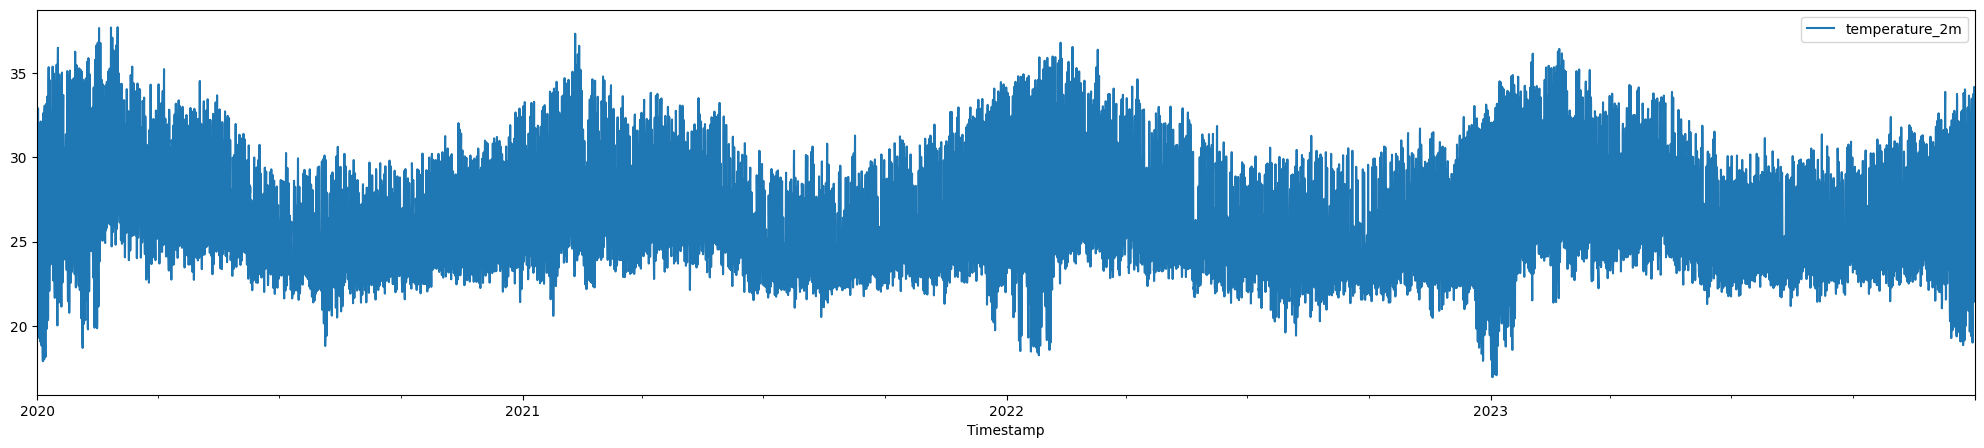

In [ ]:
new_series.plot(figsize=(25,5))

# **Définition des ensembles d’entraînement, de validation et de test**


* train - first 65% of data
* val - next 20% of data
* test - last 15% of data

In [ ]:
# Fractionner les données en 64% pour l'entraînement et 20% pour la validation pour le dataset new_series

train_size_train = int(len(new_series) * 0.65)
train_size_val = int(len(new_series) * 0.2)

ind_split_1 = train_size_train
ind_split_2 = train_size_train + train_size_val

train_data = new_series[:ind_split_1]
val_data = new_series[ind_split_1:ind_split_2]
test_data = new_series[ind_split_2:]

new_series.shape, train_data.shape, test_data.shape, val_data.shape

((11688, 1), (7597, 1), (1754, 1), (2337, 1))

In [ ]:
# Fractionner les données en 64% pour l'entraînement et 20% pour la validation pour le dataset contenant les deux variables new_series1


train_size_train_2variable = int(len(new_series1) * 0.65)
train_size_val_2variable = int(len(new_series1) * 0.2)

ind_split_1_2variable = train_size_train_2variable
ind_split_2_2variable = train_size_train_2variable + train_size_val_2variable

train_data_2variable = new_series1[:ind_split_1_2variable]
val_data_2variable = new_series1[ind_split_1_2variable:ind_split_2_2variable]
test_data_2variable = new_series1[ind_split_2_2variable:]



new_series1.shape, train_data_2variable.shape, test_data_2variable.shape, val_data_2variable.shape

((11688, 2), (7597, 2), (1754, 2), (2337, 2))

In [ ]:
#Copy des données d’entraîneuses

In [ ]:
train_data_copy_2variable = train_data_2variable.copy()
test_data_copy_2variable = test_data_2variable.copy()
val_data_copy_2variable = val_data_2variable.copy()

new_series1.shape, train_data_copy_2variable.shape, test_data_copy_2variable.shape

((11688, 2), (7597, 2), (1754, 2))

In [ ]:
train_data_copy = train_data.copy()
test_data_copy = test_data.copy()
val_data_copy = val_data.copy()

new_series.shape, train_data_copy.shape, test_data_copy.shape, val_data_copy.shape

((11688, 1), (7597, 1), (1754, 1), (2337, 1))

In [ ]:
# Effectuez l’analyse des composantes de la série temporelle
# Décomposition saisonnière de la série temporelle
def plot_seasonal_decompose (data):
        decomposition = seasonal_decompose(data['temperature_2m'], model='additive')

        # Visualisation des composantes de la série temporelle
        plt.figure(figsize=(12, 8))

        plt.subplot(4, 1, 1)
        plt.plot(new_series['temperature_2m'], label='Série Temporelle Originale')
        plt.legend(loc='best')

        plt.subplot(4, 1, 2)
        plt.plot(decomposition.trend, label='Tendance')
        plt.legend(loc='best')

        plt.subplot(4, 1, 3)
        plt.plot(decomposition.seasonal, label='Saisonnalité')
        plt.legend(loc='best')

        plt.subplot(4, 1, 4)
        plt.plot(decomposition.resid, label='Résidus')
        plt.legend(loc='best')

        plt.tight_layout()
        plt.show()


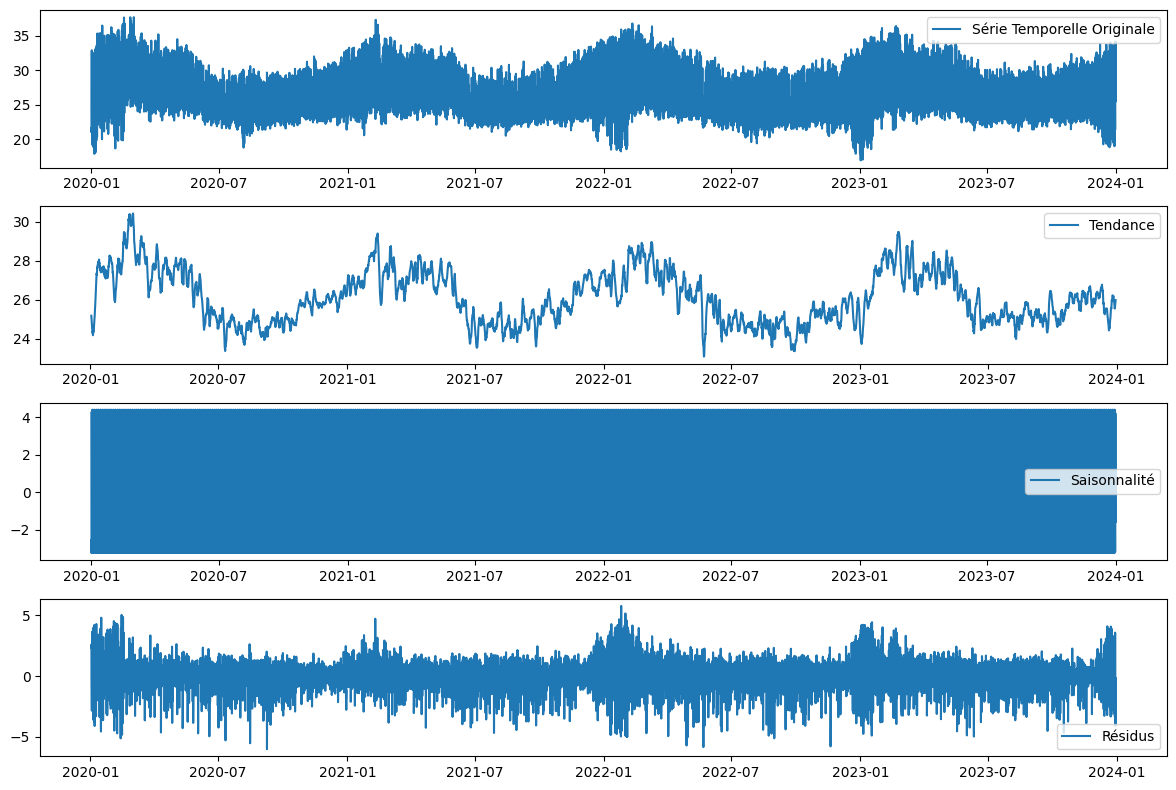

In [ ]:
plot_seasonal_decompose(new_series)

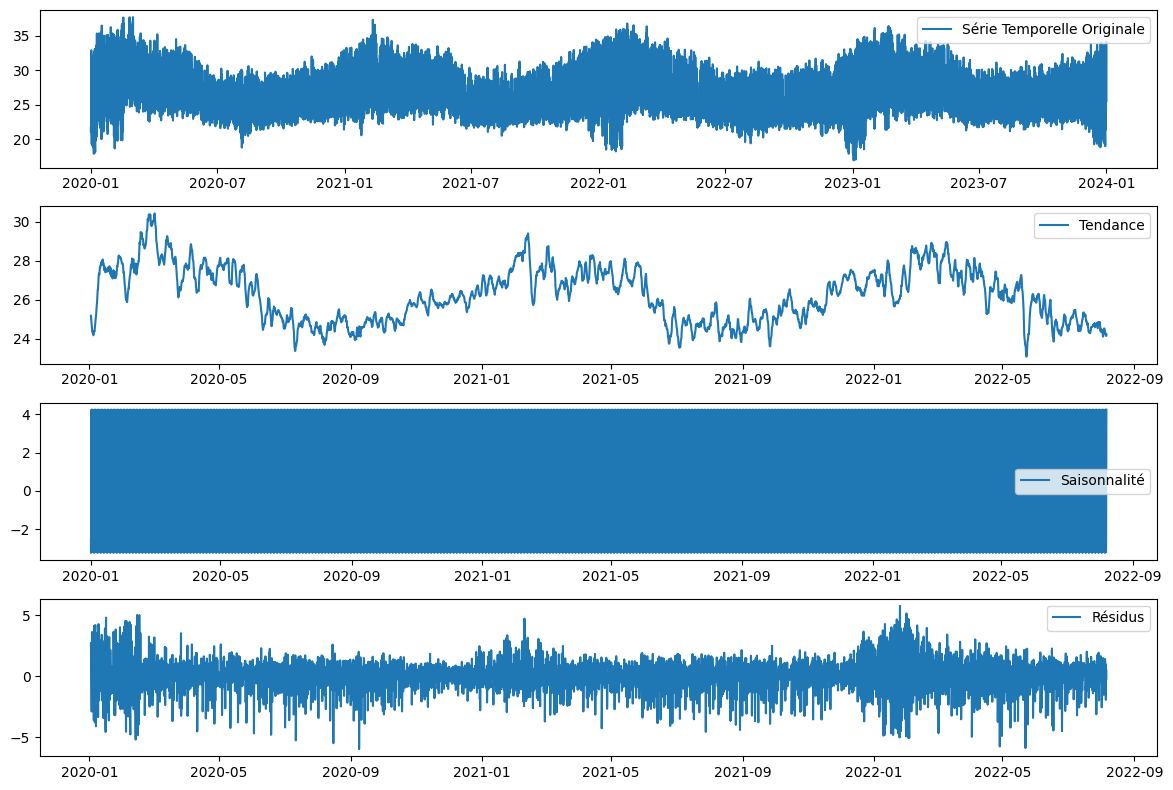

In [ ]:
plot_seasonal_decompose(train_data_copy)

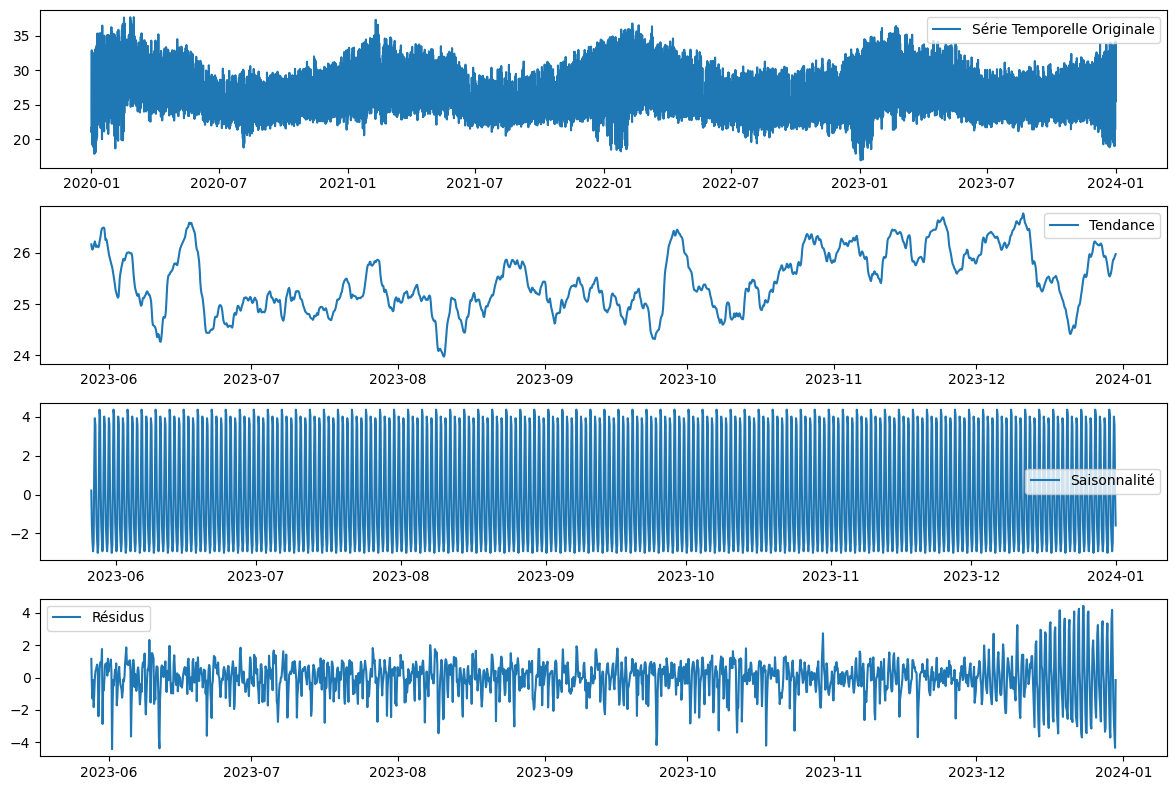

In [ ]:
plot_seasonal_decompose(test_data_copy)

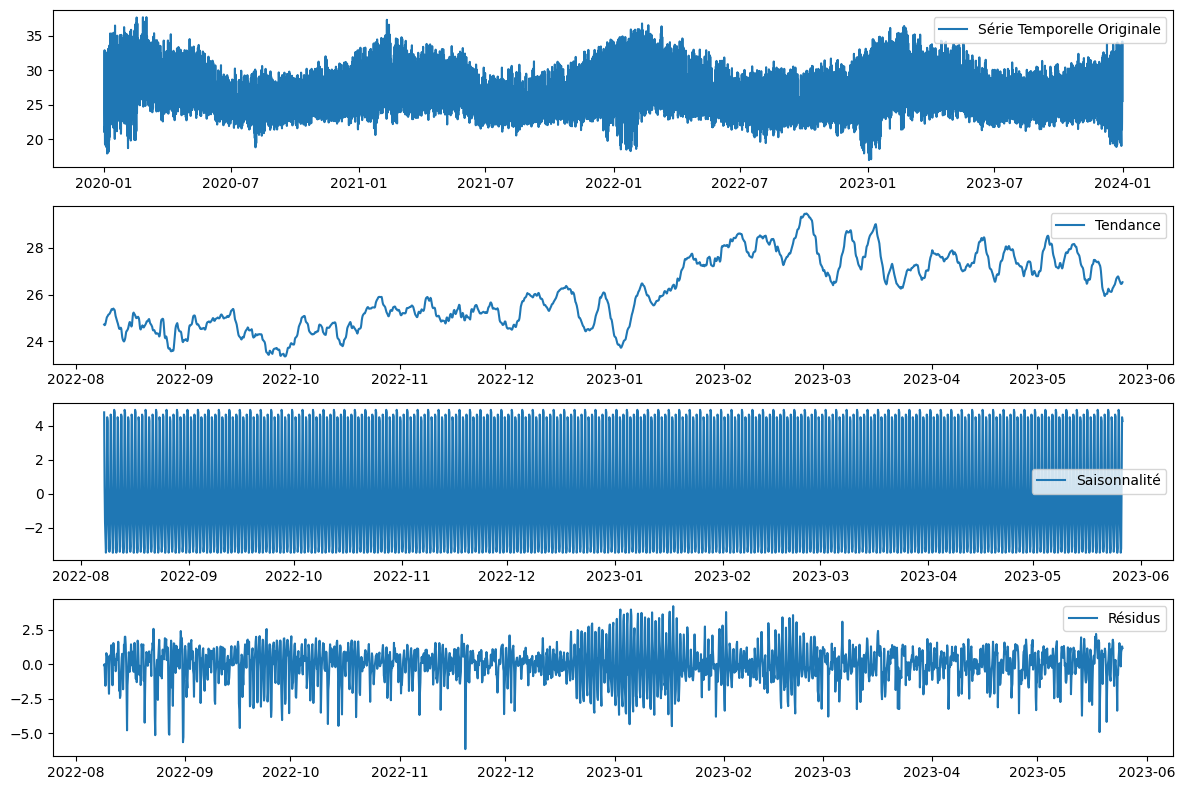

In [ ]:
plot_seasonal_decompose(val_data_copy)

In [ ]:
# ce code permet de verifier si la serie temporelle est stationnaire
# Augmented Dickey-Fuller test
def check_adf_stat(ts,data_type):

  adf_results = stattools.adfuller(ts)
  adf_stat = adf_results[0]
  p_value = adf_results[1]
  critical_values = adf_results[4]

  print(f'The Augmented Dickey-Fuller test results on {data_type}\
          \n  test statistic {adf_stat:.3f},\
          \n  p-value: {p_value:.3f}\
          \n  critical values: {critical_values}')

  if (p_value > 0.05) or (adf_stat > critical_values['5%']):
    # there is a unit root
    print('The time series is NOT stationary')
  else:
    # there is no unit roots
    print('The time series is stationary')

warnings.filterwarnings('ignore')

# Kwiatkowski–Phillips–Schmidt–Shin test
def check_kpss_stat(ts, data_type):

  kpss_results = stattools.kpss(ts)
  kpss_stat = kpss_results[0]
  p_value = kpss_results[1]
  critical_values = kpss_results[3]

  print(f'The KPSS test results on {data_type}\
        \n  test statistic {kpss_stat:.3f},\
        \n  p-value: {p_value:.3f}\
        \n  critical values: {critical_values}')

  if (p_value > 0.05) or (kpss_stat < critical_values['5%']):
      print('The time series is stationary')
  else:
      print('The time series is NOT stationary')

warnings.filterwarnings('ignore')

In [ ]:
from statsmodels.tsa import stattools

check_adf_stat(train_data_copy, 'Train')
print("***"*30)
check_kpss_stat(train_data_copy, 'Train')
print("+++"*30)
check_adf_stat(test_data_copy, 'Test')
print("***"*30)
check_kpss_stat(test_data_copy, 'Test')

The Augmented Dickey-Fuller test results on Train          
  test statistic -4.967,          
  p-value: 0.000          
  critical values: {'1%': -3.4312148229223345, '5%': -2.8619221867340787, '10%': -2.5669734335489633}
The time series is stationary
******************************************************************************************
The KPSS test results on Train        
  test statistic 1.270,        
  p-value: 0.010        
  critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The time series is NOT stationary
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
The Augmented Dickey-Fuller test results on Test          
  test statistic -5.121,          
  p-value: 0.000          
  critical values: {'1%': -3.4341399541217137, '5%': -2.8632140530328685, '10%': -2.567661218506194}
The time series is stationary
******************************************************************************************
The KPSS test re

train_data_copy est une série temporelle (probablement une pandas Series ou un DataFrame avec une colonne spécifique).

train_data_copy.shift(1) décale la série temporelle d'une période vers le haut. Cela crée une nouvelle série temporelle où chaque valeur est décalée d'une unité par rapport à la valeur correspondante dans train_data_copy.

(train_data_copy - train_data_copy.shift(1)) effectue une soustraction élément par élément entre la série originale et la série décalée.

Cela calcule la différence entre chaque valeur et sa valeur précédente.

diff_y_train_copy contient maintenant les différences entre les valeurs successives de la série temporelle.


**Le but principal de ce code est donc de transformer la série temporelle train_data_copy en une série temporelle différenciée, ce qui peut être utile pour supprimer des tendances ou des motifs spécifiques dans les données. Cela peut être nécessaire pour certains modèles ou analyses qui nécessitent des séries temporelles stationnaires ou dont les variations sont plus facilement modélisables.**

In [ ]:


diff_y_train_copy = (train_data_copy - train_data_copy.shift(1))

diff_y_train_copy.dropna(inplace=True)
diff_y_train_copy.plot(figsize=(25,5));

In [ ]:
diff_y_test_copy = (test_data_copy - test_data_copy.shift(1))

diff_y_test_copy.dropna(inplace=True)
diff_y_test_copy.plot(figsize=(25,5));

In [ ]:
check_adf_stat(diff_y_train_copy, 'Train')
print("***"*30)
check_kpss_stat(diff_y_train_copy, 'Train')
print("+++"*30)
check_adf_stat(diff_y_test_copy, 'Test')
print("***"*30)
check_kpss_stat(diff_y_test_copy, 'Test')

In [ ]:
### Seasonal differencing

#From the figure we can see that the pattern is repeated every ....time steps (months).

In [ ]:
s = 15
sdiff_y_train_copy = (diff_y_train_copy - diff_y_train_copy.shift(s))[s:]

sdiff_y_train_copy.dropna(inplace=True)
sdiff_y_train_copy.plot(figsize=(25,5));

In [ ]:
s = 15
sdiff_y_test_copy = (diff_y_test_copy - diff_y_test_copy.shift(s))[s:]

sdiff_y_test_copy.dropna(inplace=True)
sdiff_y_test_copy.plot(figsize=(25,5));

In [ ]:
check_adf_stat(sdiff_y_train_copy, 'Train')
print("***"*30)
check_kpss_stat(sdiff_y_train_copy, 'Train')
print("+++"*30)
check_adf_stat(sdiff_y_test_copy, 'Test')
print("***"*30)
check_kpss_stat(sdiff_y_test_copy, 'Test')

The Augmented Dickey-Fuller test results on Train          
  test statistic -29.621,          
  p-value: 0.000          
  critical values: {'1%': -3.4310537231669236, '5%': -2.861851001180975, '10%': -2.5669355408505097}
The time series is stationary
******************************************************************************************
The KPSS test results on Train        
  test statistic 0.011,        
  p-value: 0.100        
  critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The time series is stationary
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
The Augmented Dickey-Fuller test results on Test          
  test statistic -17.479,          
  p-value: 0.000          
  critical values: {'1%': -3.4331988336181656, '5%': -2.8627985509372906, '10%': -2.567439983623706}
The time series is stationary
******************************************************************************************
The KPSS test resul

In [ ]:
import numpy as np

y_train_log = np.log(train_data_copy)
y_test_log = np.log(test_data_copy)

In [ ]:
y_train_log.plot(figsize=(25,5))
y_test_log.plot(figsize=(25,5))

In [ ]:
### Autocorrelaction function (ACF)

In [ ]:
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_acf(sdiff_y_train_copy, lags=40, ax=ax1, title="ACF: Stationarized TS (diff + sdiff)");

In [ ]:
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_acf(train_data_copy, lags=40, ax=ax1, title="ACF: Initial TS");

In [ ]:
### Partial Autocorrelation function (PACF)

In [ ]:
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(211)
tsaplots.plot_pacf(sdiff_y_train_copy, lags=40, ax=ax1, title="PACF: Stationarized TS (diff + sdiff)");

In [ ]:
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_pacf(train_data_copy, lags=40, ax=ax1, title="PACF: Initial TS")

# **Modélisation et évaluation des performances des modèles**

In [ ]:
# Modélisation et évaluation des perfo rmances des modèles

In [ ]:
### ARIMA

In [ ]:

#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Pour ARIMA (p,d,q)

# Définissez le modèle SARIMA
model = ARIMA(train_data_copy, order=(22,1,22))

# Entraînez le modèle
model_fit2 = model.fit()


print(model_fit2.summary())

                               SARIMAX Results                                
Dep. Variable:         temperature_2m   No. Observations:                 7597
Model:               ARIMA(22, 1, 22)   Log Likelihood               -9277.733
Date:                Sat, 06 Apr 2024   AIC                          18645.466
Time:                        22:53:36   BIC                          18957.558
Sample:                    01-01-2020   HQIC                         18752.568
                         - 08-07-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1976      0.851     -0.232      0.816      -1.866       1.471
ar.L2         -0.3852      0.705     -0.547      0.585      -1.766       0.996
ar.L3         -0.3297      0.651     -0.506      0.6

In [ ]:
forecast = model_fit2.forecast(steps=10)
print(forecast)

2022-08-07 15:00:00    29.648328
2022-08-07 18:00:00    26.205480
2022-08-07 21:00:00    23.335250
2022-08-08 00:00:00    21.527112
2022-08-08 03:00:00    20.826462
2022-08-08 06:00:00    21.569979
2022-08-08 09:00:00    25.569942
2022-08-08 12:00:00    28.078552
2022-08-08 15:00:00    28.789212
2022-08-08 18:00:00    25.808321
Freq: 3H, Name: predicted_mean, dtype: float64


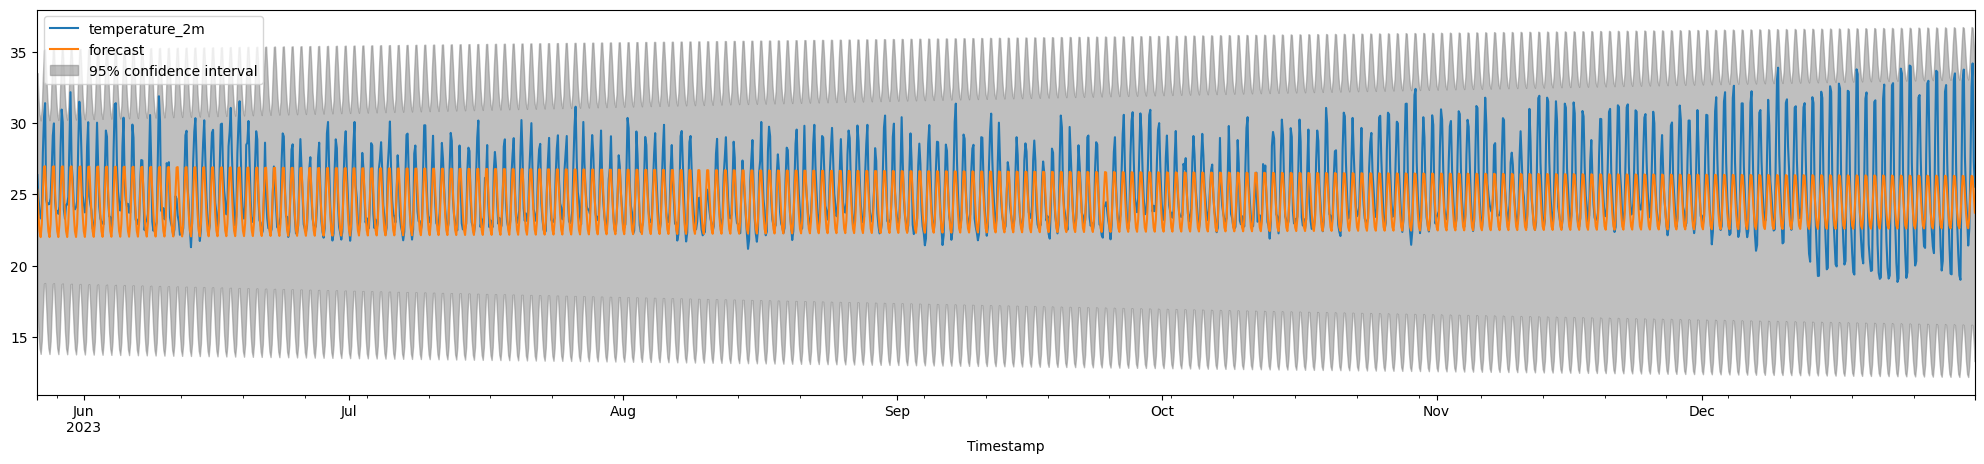

In [ ]:
fig, ax = plt.subplots(figsize=(25,5))
ax = test_data.plot(ax=ax, label='Test Data')
fig = plot_predict(model_fit2, start=test_data.index[0], end=test_data.index[-1], dynamic=False, ax=ax)
legend = ax.legend(loc="upper left")
plt.show()

In [ ]:
# From PACF plot
p_values = range(0,30)
# From ACF plot
q_values = range(0,30)
# We saw that single differencing transformed the ts into a stationary one
d_values = range(0,2)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import itertools


best_order_aic_score_1, best_order_aic_cfg_1 = float("inf"), None

# Générer toutes les combinaisons possibles de p, d, q
orders = list(itertools.product(p_values, d_values, q_values))

for order in orders:
    try:
        model = ARIMA(train_data, order=order).fit()
        if model.aic < best_order_aic_score_1:
            best_order_aic_score_1, best_order_aic_cfg_1 = model.aic, order
            print(f'ARIMA{order} AIC={model.aic:.3f}')
    except:
        continue

print(f'Best ARIMA{best_order_aic_cfg_1} AIC={best_order_aic_score_1:.3f}')


ARIMA(0, 0, 0) AIC=49695.964
ARIMA(0, 0, 1) AIC=42394.557
ARIMA(0, 0, 2) AIC=37829.894
ARIMA(0, 0, 3) AIC=37103.353
ARIMA(0, 0, 5) AIC=36182.428
ARIMA(0, 0, 6) AIC=36151.527
ARIMA(0, 0, 7) AIC=35122.509
ARIMA(0, 0, 9) AIC=33487.353
ARIMA(1, 0, 9) AIC=32820.292
ARIMA(2, 0, 4) AIC=32155.004
ARIMA(2, 0, 5) AIC=31935.902
ARIMA(2, 0, 6) AIC=31014.995
ARIMA(2, 0, 7) AIC=30445.907
ARIMA(2, 0, 8) AIC=29739.987
ARIMA(2, 0, 9) AIC=29584.330
ARIMA(2, 1, 6) AIC=29257.991
ARIMA(2, 1, 7) AIC=28937.091
ARIMA(2, 1, 8) AIC=28773.376
ARIMA(2, 1, 9) AIC=28478.369
ARIMA(3, 1, 7) AIC=28452.621
ARIMA(3, 1, 9) AIC=28041.174
ARIMA(4, 0, 8) AIC=26933.763
ARIMA(4, 1, 4) AIC=26577.924
ARIMA(4, 1, 5) AIC=25408.454
ARIMA(4, 1, 7) AIC=25222.811
ARIMA(4, 1, 8) AIC=25149.742
ARIMA(5, 0, 7) AIC=24982.880
ARIMA(5, 0, 8) AIC=24743.221
ARIMA(5, 1, 6) AIC=24618.721
ARIMA(5, 1, 7) AIC=24177.341
ARIMA(5, 1, 8) AIC=24048.844
ARIMA(5, 1, 9) AIC=23872.213
ARIMA(6, 0, 8) AIC=23866.599
ARIMA(6, 0, 9) AIC=23774.527
Best ARIMA(6, 

In [ ]:
#SARIMAX

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Définir les ordres pour le modèle SARIMAX
order =(11,1,11)

# Ajuster le modèle SARIMAX
model_fit_temperature = SARIMAX(train_data_copy, order=order).fit()

# Afficher le résumé du modèle
print(model_fit_temperature.summary())

                               SARIMAX Results                                
Dep. Variable:         temperature_2m   No. Observations:                 7597
Model:             SARIMAX(11, 1, 11)   Log Likelihood               -9669.482
Date:                Sat, 06 Apr 2024   AIC                          19384.964
Time:                        22:56:00   BIC                          19544.478
Sample:                    01-01-2020   HQIC                         19439.705
                         - 08-07-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6766      0.042    -16.219      0.000      -0.758      -0.595
ar.L2          0.2372      0.035      6.713      0.000       0.168       0.306
ar.L3          0.6032      0.037     16.207      0.0

In [ ]:
forecast1 = model_fit_temperature.forecast(steps=10)

print(forecast1)

2022-08-07 15:00:00    29.451589
2022-08-07 18:00:00    26.501759
2022-08-07 21:00:00    23.875602
2022-08-08 00:00:00    21.790478
2022-08-08 03:00:00    21.275809
2022-08-08 06:00:00    21.739227
2022-08-08 09:00:00    25.458198
2022-08-08 12:00:00    28.134283
2022-08-08 15:00:00    28.520671
2022-08-08 18:00:00    25.781003
Freq: 3H, Name: predicted_mean, dtype: float64


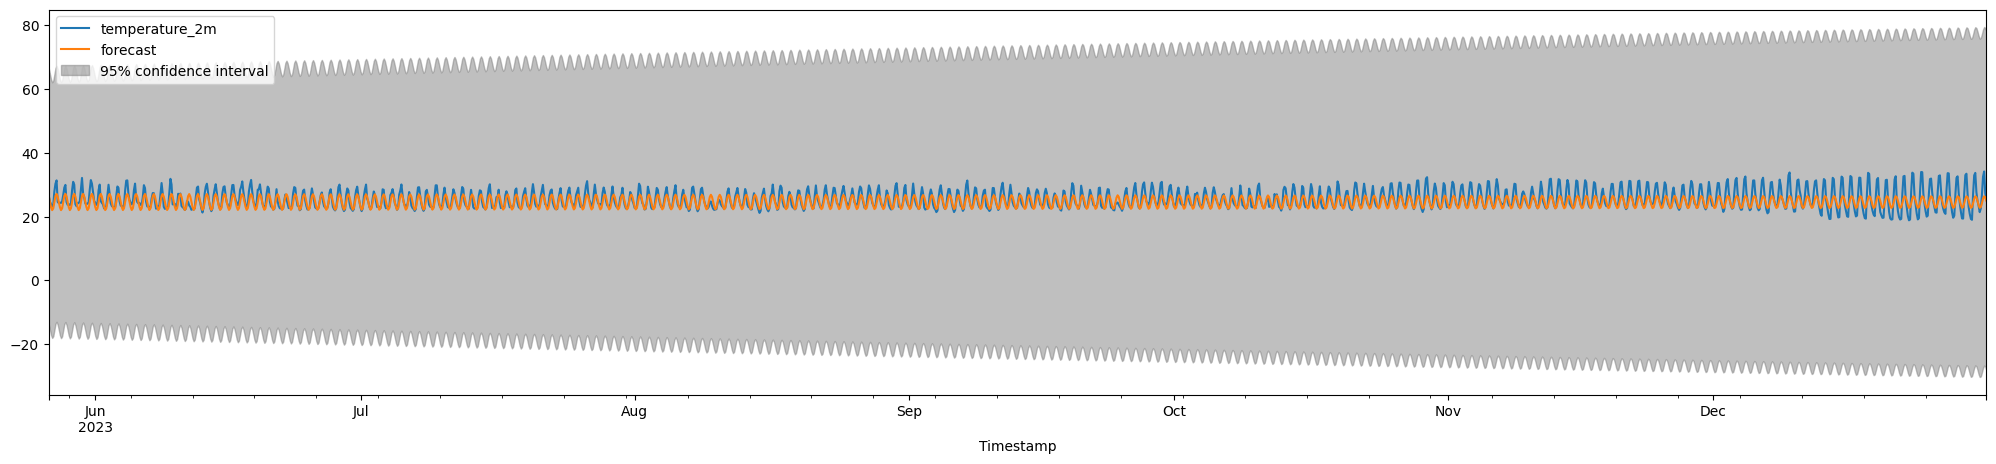

In [ ]:
fig, ax = plt.subplots(figsize=(25,5))
ax = test_data.plot(ax=ax, label='Test Data')
fig = plot_predict(model_fit_temperature, start=test_data_copy.index[0], end=test_data_copy.index[-1], dynamic=False, ax=ax)
legend = ax.legend(loc="upper left")
plt.show()

In [ ]:
# From PACF plot
p_values = range(0,12)
# From ACF plot
q_values = range(0,12)
# We saw that single differencing transformed the ts into a stationary one
d_values = range(0,2)

In [ ]:
best_order_aic_score, best_order_aic_cfg = float("inf"), None

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                model_sa_t = SARIMAX(train_data_copy, order=order).fit()
                if model_sa_t.aic < best_order_aic_score:
                    best_order_aic_score, best_order_aic_cfg = model_sa_t.aic, order
                    print(f'SARIMAX{order} AIC={model_sa_t.aic:.3f}')
            except:
                continue

print(f'Best SARIMAX{best_order_aic_cfg} AIC={best_order_aic_score:.3f}')

SARIMAX(0, 0, 0) AIC=71328.467
SARIMAX(0, 0, 1) AIC=61647.483
SARIMAX(0, 0, 2) AIC=52647.613
SARIMAX(0, 0, 3) AIC=47143.489
SARIMAX(0, 0, 4) AIC=41797.262
SARIMAX(0, 0, 5) AIC=40091.750
SARIMAX(0, 0, 6) AIC=37038.492
SARIMAX(0, 0, 7) AIC=35547.444
SARIMAX(0, 0, 10) AIC=33324.720
SARIMAX(0, 1, 2) AIC=32800.455
SARIMAX(0, 1, 3) AIC=30054.049
SARIMAX(0, 1, 4) AIC=29623.612
SARIMAX(0, 1, 5) AIC=29543.415
SARIMAX(0, 1, 6) AIC=27953.404
SARIMAX(0, 1, 7) AIC=27950.754
SARIMAX(0, 1, 8) AIC=27311.175
SARIMAX(0, 1, 9) AIC=27057.107
SARIMAX(0, 1, 10) AIC=26353.079
SARIMAX(0, 1, 11) AIC=25595.215
SARIMAX(1, 1, 11) AIC=25586.716
SARIMAX(2, 1, 4) AIC=24300.151
SARIMAX(2, 1, 5) AIC=24251.490
SARIMAX(2, 1, 6) AIC=23362.253
SARIMAX(2, 1, 7) AIC=23194.994
SARIMAX(2, 1, 9) AIC=23150.056
SARIMAX(2, 1, 10) AIC=22406.220
SARIMAX(2, 1, 11) AIC=22323.643
SARIMAX(3, 0, 11) AIC=22177.510
SARIMAX(4, 0, 11) AIC=22099.159
SARIMAX(4, 1, 4) AIC=21572.806
SARIMAX(4, 1, 5) AIC=20535.995
SARIMAX(4, 1, 6) AIC=20512.597


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

best_score_rmse, best_cfg_rmse = float("inf"), None

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                model = SARIMAX(train_data_copy, order=order).fit()
                ts_pred = model.predict(start=test_data_copy.index[0], end=test_data_copy.index[-1])
                rmse = mean_squared_error(test_data_copy.values, ts_pred.values, squared=False)

                if rmse < best_score_rmse:
                    best_score_rmse, best_cfg_rmse = rmse, order
                    print(f'SARIMAX{order} RMSE={rmse:.3f}')
            except:
                continue

print(f'Best SARIMAX{best_cfg_rmse} RMSE={best_score_rmse:.3f}')

SARIMAX(0, 0, 0) RMSE=25.624
SARIMAX(0, 1, 0) RMSE=4.866
SARIMAX(0, 1, 1) RMSE=4.735
SARIMAX(0, 1, 2) RMSE=4.257
SARIMAX(0, 1, 3) RMSE=3.078
SARIMAX(0, 1, 4) RMSE=3.060
SARIMAX(1, 1, 5) RMSE=3.052
SARIMAX(2, 1, 0) RMSE=3.000
SARIMAX(3, 0, 4) RMSE=2.855
SARIMAX(3, 0, 6) RMSE=2.592
SARIMAX(3, 1, 5) RMSE=1.997
SARIMAX(3, 1, 7) RMSE=1.979
SARIMAX(9, 1, 9) RMSE=1.885
Best SARIMAX(9, 1, 9) RMSE=1.885


In [ ]:
from sklearn.metrics import mean_squared_error
#######################
ts_train_val = pd.concat([train_data_copy,val_data_copy], axis=0)
best_order = (9,1,9)
model_sarimax = SARIMAX(ts_train_val, order=best_order).fit()
ts_pred = model_sarimax.predict(start=test_data_copy.index[0], end=test_data_copy.index[-1])
rmse = mean_squared_error(test_data_copy.values, ts_pred.values, squared=False)
print(f'SARIMAX{best_order}\nAIC={model_sarimax.aic:.2f}\nRMSE (test)={rmse:.2f}')

SARIMAX(9, 1, 9)
AIC=26355.31
RMSE (test)=2.25


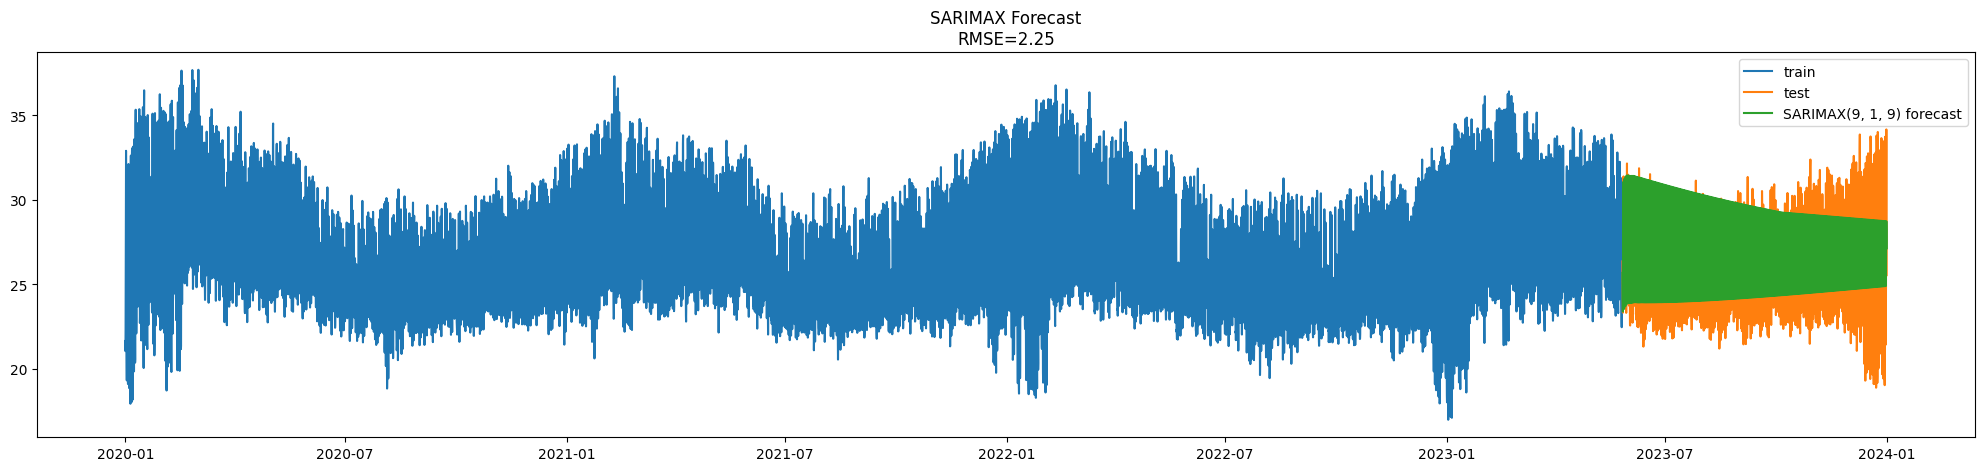

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(ts_train_val.index, ts_train_val.values, label='train')
plt.plot(test_data_copy.index, test_data_copy.values, label='test')
plt.plot(ts_pred.index, ts_pred.values, label=f'SARIMAX{best_order} forecast')
plt.legend(loc='best')
plt.title(f'SARIMAX Forecast\nRMSE={rmse:.2f}')
plt.show()

In [ ]:
P_values = range(0,2)
Q_values = range(0,4)
D_values = range(0,2)
s = 8

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (9,1,9)
best_score_aic, best_cfg_aic = float("inf"), None

for P in P_values:
    for D in D_values:
        for Q in Q_values:
            seasonal_order=(P, D, Q, s)
            try:
                model = SARIMAX(train_data_copy, order=order, seasonal_order=seasonal_order).fit()
                if model.aic < best_score_aic:
                    best_score_aic, best_cfg_aic = model.aic, seasonal_order
                    print(f'SARIMAX{order}{seasonal_order} AIC={model.aic:.3f}')
            except:
                continue

print(f'Best SARIMAX{order}{best_cfg_aic} AIC={best_score_aic:.3f}')

SARIMAX(9, 1, 9)(0, 0, 0, 8) AIC=19844.208
SARIMAX(9, 1, 9)(0, 1, 0, 8) AIC=18791.007
Best SARIMAX(9, 1, 9)(0, 1, 0, 8) AIC=18791.007


In [ ]:
from sklearn.metrics import mean_squared_error

ts_train_val = pd.concat([train_data_copy,val_data_copy], axis=0)
order = (9,1,9)
seasonal_order = (0, 1, 0, 8)
model_sarimax = SARIMAX(ts_train_val, order=order, seasonal_order=seasonal_order).fit()
ts_pred = model_sarimax.predict(start=test_data_copy.index[0], end=test_data_copy.index[-1])
rmse = mean_squared_error(test_data_copy.values, ts_pred.values, squared=False)
print(f'SARIMAX{order}{seasonal_order}\nAIC={model_sarimax.aic:.2f}\nRMSE (test)={rmse:.2f}')

SARIMAX(9, 1, 9)(0, 1, 0, 8)
AIC=25028.09
RMSE (test)=2.04


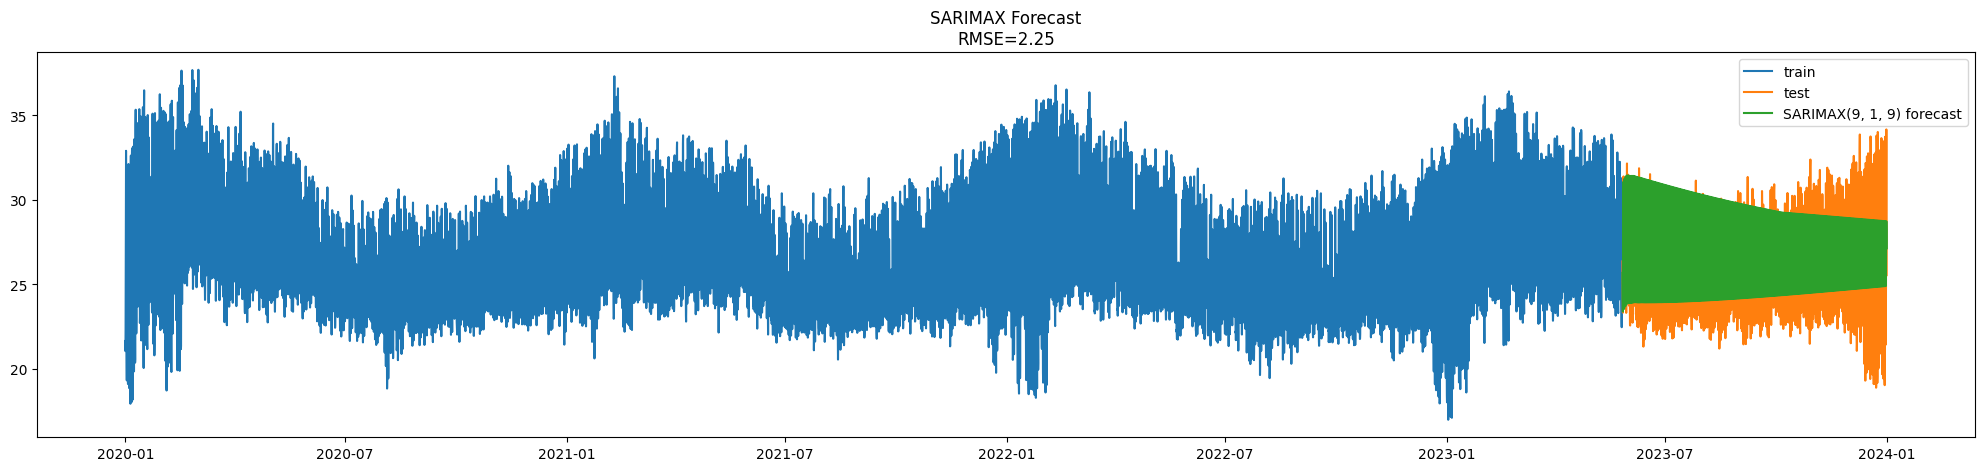

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(ts_train_val.index, ts_train_val.values, label='train')
plt.plot(test_data_copy.index, test_data_copy.values, label='test')
plt.plot(ts_pred.index, ts_pred.values, label=f'SARIMAX{best_order} forecast')
plt.legend(loc='best')
plt.title(f'SARIMAX Forecast\nRMSE={rmse:.2f}')
plt.show()

#Ameliorons  le modèle en ajoutant une variable suplementaire (relative_humidity_2m)

In [ ]:
# new_series1 est une datafram qui contient la variable supplémentaire elative_humidity_2m

new_series1.drop(columns=['temperature_2m'], inplace=True)

print(new_series1)


                     relative_humidity_2m
Timestamp                                
2020-01-01 00:00:00             88.314089
2020-01-01 03:00:00             94.095755
2020-01-01 06:00:00             95.356007
2020-01-01 09:00:00             74.370657
2020-01-01 12:00:00             32.997973
...                                   ...
2023-12-31 09:00:00             76.299993
2023-12-31 12:00:00             44.493048
2023-12-31 15:00:00             32.328162
2023-12-31 18:00:00             55.907164
2023-12-31 21:00:00             45.632521

[11688 rows x 1 columns]


**Ce code effectue une normalisation Min-Max sur deux séries temporelles (new_series et new_series1) à l'aide de MinMaxScaler de Scikit-Learn, puis il les trace dans un graphique**

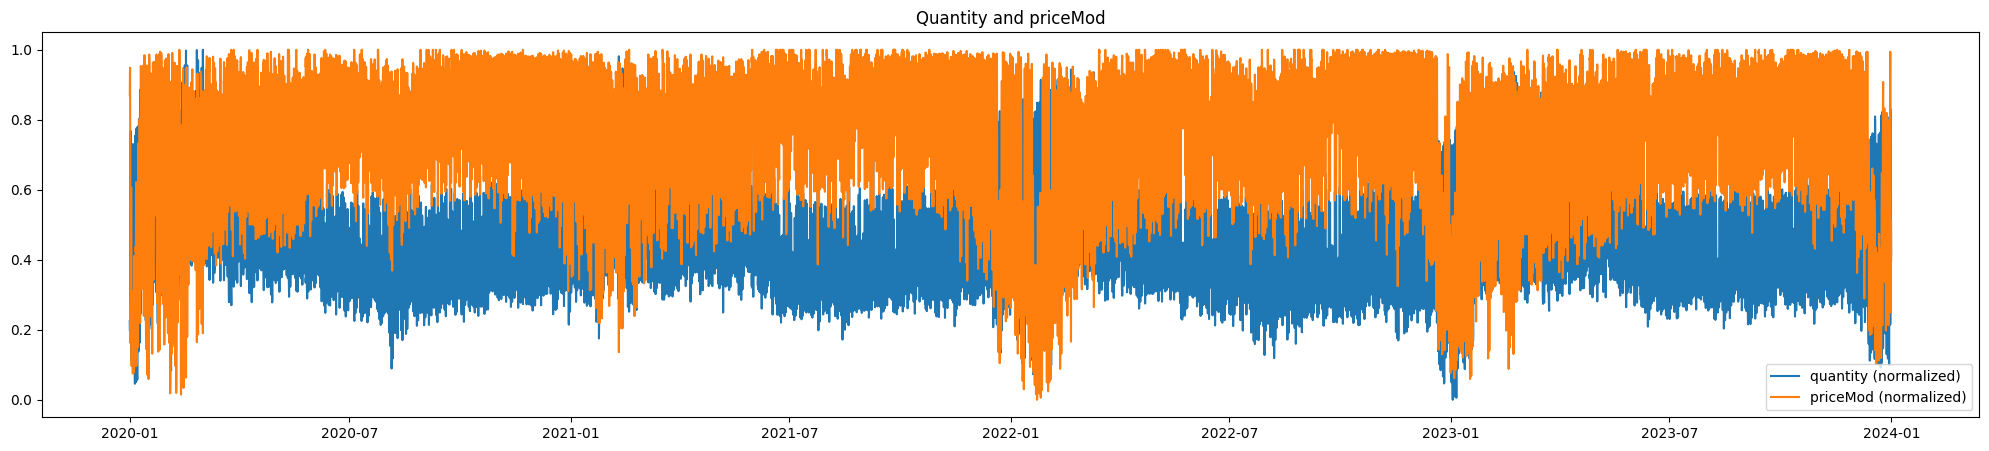

In [ ]:
from sklearn.preprocessing import MinMaxScaler

priceMod_normalized = MinMaxScaler(feature_range=(0, 1)).fit_transform(new_series1.values.reshape(-1, 1))
new_series_normalized = MinMaxScaler(feature_range=(0, 1)).fit_transform(new_series.values.reshape(-1, 1))

plt.figure(figsize=(25,5))
plt.plot(new_series.index, new_series_normalized, label='quantity (normalized)')
plt.plot(new_series1.index, priceMod_normalized, label='priceMod (normalized)')
plt.legend(loc='best')
plt.title('Quantity and priceMod')
plt.show()

In [ ]:
# Fractionner les données en 80% pour l'entraînement et 20% pour le test
train_size_2variable = int(len(new_series1) * 0.8)

train_data_2variable = new_series1[:train_size_2variable]
test_data_2variable = new_series1[train_size_2variable:]


new_series1.shape, train_data_2variable.shape, test_data_2variable.shape

((11688, 2), (9350, 2), (2338, 2))

In [ ]:
from sklearn.metrics import mean_squared_error

# Aligner les index des données endogènes et exogènes
train_data, train_data_2variable = train_data.align(train_data_2variable, join='inner', axis=0)

order = (9, 1, 9)
seasonal_order = (0, 1, 0, 8)
model_sarimax_exog = SARIMAX(train_data, exog=train_data_2variable, order=order, seasonal_order=seasonal_order).fit()
ts_pred_exog = model_sarimax_exog.predict(start=test_data.index[0], end=test_data.index[-1], exog=test_data_2variable)
rmse = mean_squared_error(test_data.values, ts_pred_exog.values, squared=False)

ValueError: Provided exogenous values are not of the appropriate shape. Required (4091, 2), got (2338, 2).

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(train_data.index, train_data.values, label='train')
plt.plot(test_data.index, test_data.values, label='test')
plt.plot(ts_pred_exog.index, ts_pred_exog.values, label=f'SARIMAX{order} forecast')
plt.legend(loc='best')
plt.title(f'SARIMAX{order}{seasonal_order} Forecast\nRMSE={rmse:.2f}')
plt.show()

In [ ]:
# Les Methodes ML

In [ ]:
# Regression Lineaire

In [ ]:
new_series_ML

,temperature_2m,relative_humidity_2m
Timestamp,,
2020-01-01 00:00:00,21.639834,88.314089
2020-01-01 03:00:00,21.039834,94.095755
2020-01-01 06:00:00,22.339833,95.356007
2020-01-01 09:00:00,26.123167,74.370657
2020-01-01 12:00:00,32.339833,32.997973
...,...,...
2023-12-31 09:00:00,26.906500,76.299993
2023-12-31 12:00:00,32.539833,44.493048
2023-12-31 15:00:00,34.173167,32.328162


In [ ]:
column_value ='temperature_2m'

In [ ]:
for i in range(1, 10):
    new_series_ML[f"lag_{i}"] = new_series_ML[column_value].shift(i)
new_series_ML.head()

,temperature_2m,relative_humidity_2m,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9
Timestamp,,,,,,,,,,,
2020-01-01 00:00:00,21.639834,88.314089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 03:00:00,21.039834,94.095755,21.639834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 06:00:00,22.339833,95.356007,21.039834,21.639834,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 09:00:00,26.123167,74.370657,22.339833,21.039834,21.639834,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 12:00:00,32.339833,32.997973,26.123167,22.339833,21.039834,21.639834,NaN,NaN,NaN,NaN,NaN


In [ ]:
new_series_ML.dropna(inplace=True)
new_series_ML.head()

,temperature_2m,relative_humidity_2m,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9
Timestamp,,,,,,,,,,,
2020-01-02 03:00:00,19.523167,64.513025,22.389833,24.239834,26.739834,32.906500,32.339833,26.123167,22.339833,21.039834,21.639834
2020-01-02 06:00:00,19.306500,57.791526,19.523167,22.389833,24.239834,26.739834,32.906500,32.339833,26.123167,22.339833,21.039834
2020-01-02 09:00:00,26.906500,27.617350,19.306500,19.523167,22.389833,24.239834,26.739834,32.906500,32.339833,26.123167,22.339833
2020-01-02 12:00:00,31.889833,18.508160,26.906500,19.306500,19.523167,22.389833,24.239834,26.739834,32.906500,32.339833,26.123167
2020-01-02 15:00:00,31.939833,26.255131,31.889833,26.906500,19.306500,19.523167,22.389833,24.239834,26.739834,32.906500,32.339833


Split data into train and test sets.

*   train - the first 80% of data
*   test - the last 20% of data

In [ ]:
from sklearn.model_selection import train_test_split

X = new_series_ML.drop(column_value, axis=1)
y = new_series_ML[column_value]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
X

,relative_humidity_2m,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9
Timestamp,,,,,,,,,,
2020-01-02 03:00:00,64.513025,22.389833,24.239834,26.739834,32.906500,32.339833,26.123167,22.339833,21.039834,21.639834
2020-01-02 06:00:00,57.791526,19.523167,22.389833,24.239834,26.739834,32.906500,32.339833,26.123167,22.339833,21.039834
2020-01-02 09:00:00,27.617350,19.306500,19.523167,22.389833,24.239834,26.739834,32.906500,32.339833,26.123167,22.339833
2020-01-02 12:00:00,18.508160,26.906500,19.306500,19.523167,22.389833,24.239834,26.739834,32.906500,32.339833,26.123167
2020-01-02 15:00:00,26.255131,31.889833,26.906500,19.306500,19.523167,22.389833,24.239834,26.739834,32.906500,32.339833
...,...,...,...,...,...,...,...,...,...,...
2023-12-31 09:00:00,76.299993,22.606500,21.423167,23.456500,24.939833,27.673167,33.739833,32.956500,27.106500,19.023167
2023-12-31 12:00:00,44.493048,26.906500,22.606500,21.423167,23.456500,24.939833,27.673167,33.739833,32.956500,27.106500
2023-12-31 15:00:00,32.328162,32.539833,26.906500,22.606500,21.423167,23.456500,24.939833,27.673167,33.739833,32.956500


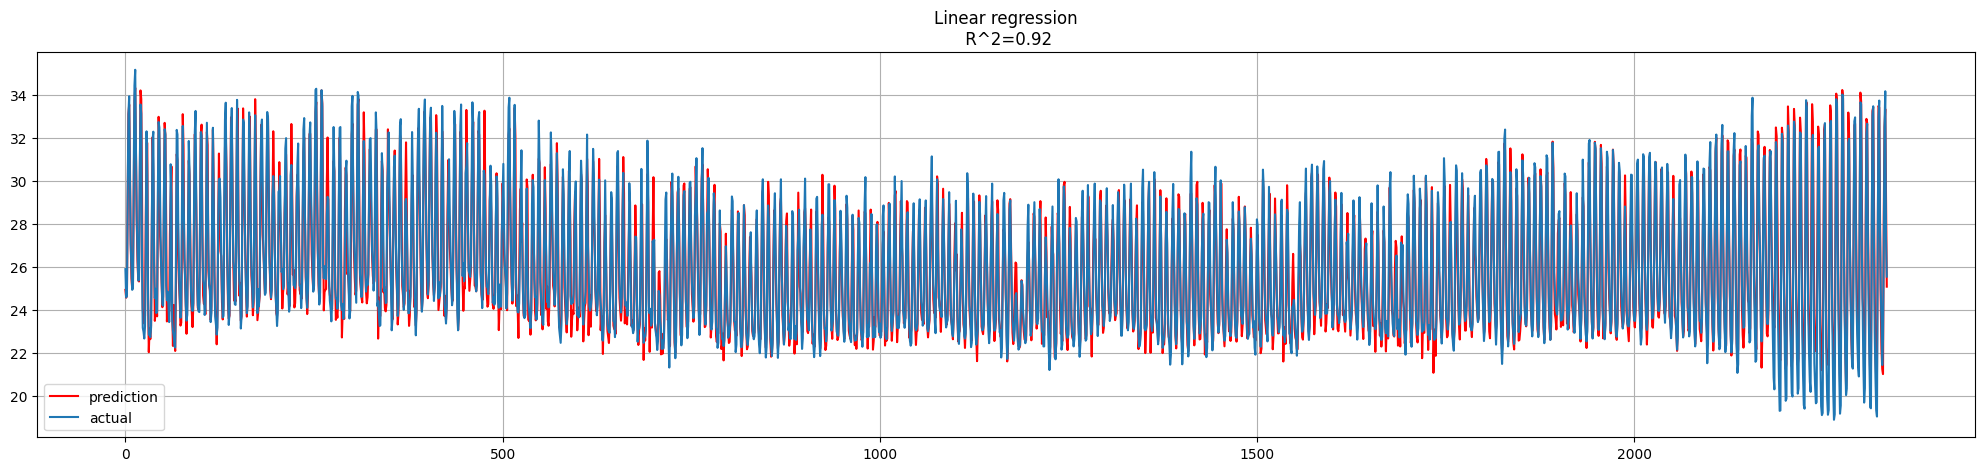

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

plt.figure(figsize=(25, 5))
plt.plot(y_pred, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n R^2={r2_score(y_test, y_pred):.2f}");

### Tâche 4. Caractéristiques agrégées et fonction de prétraitement

Définir une fonction de prétraitement en suivant les étapes suivantes :

1.   Diviser les données en ensembles de formation et de test avec une taille de test par défaut de 15 %.
2.   Ajouter des caractéristiques de décalage pour une plage de décalages donnée (les 7 premiers par défaut).
3.   Ajouter des caractéristiques agrégées prédéfinies (moyenne mensuelle)

In [ ]:
test1 = test.copy()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

def preprocess_data(data, lag_start=1, lag_end=3, test_size=0.2):
    data = pd.DataFrame(data.copy())

    # Ajout des retards (lags) comme caractéristiques
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data['temperature_2m'].shift(i)

    # Supprimer les lignes contenant des valeurs manquantes générées par l'ajout des retards
    data = data.dropna()

    # Séparation des données en ensembles d'entraînement et de test
    X = data.drop(['temperature_2m'], axis=1)  # Caractéristiques excluant la date et la température


    y = data['temperature_2m']  # Variable cible : température à 2m

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    return X_train, X_test, y_train, y_test

# Utilisation de la fonction preprocess_data avec votre jeu de données "data"
# Vous pouvez définir les paramètres lag_start, lag_end, et test_size selon vos besoins
X_train, X_test, y_train, y_test = preprocess_data(test1, lag_start=1, lag_end=4, test_size=0.2)

# Vérification des dimensions des ensembles
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (9348, 4), y_train shape: (9348,)
X_test shape: (2337, 4), y_test shape: (2337,)


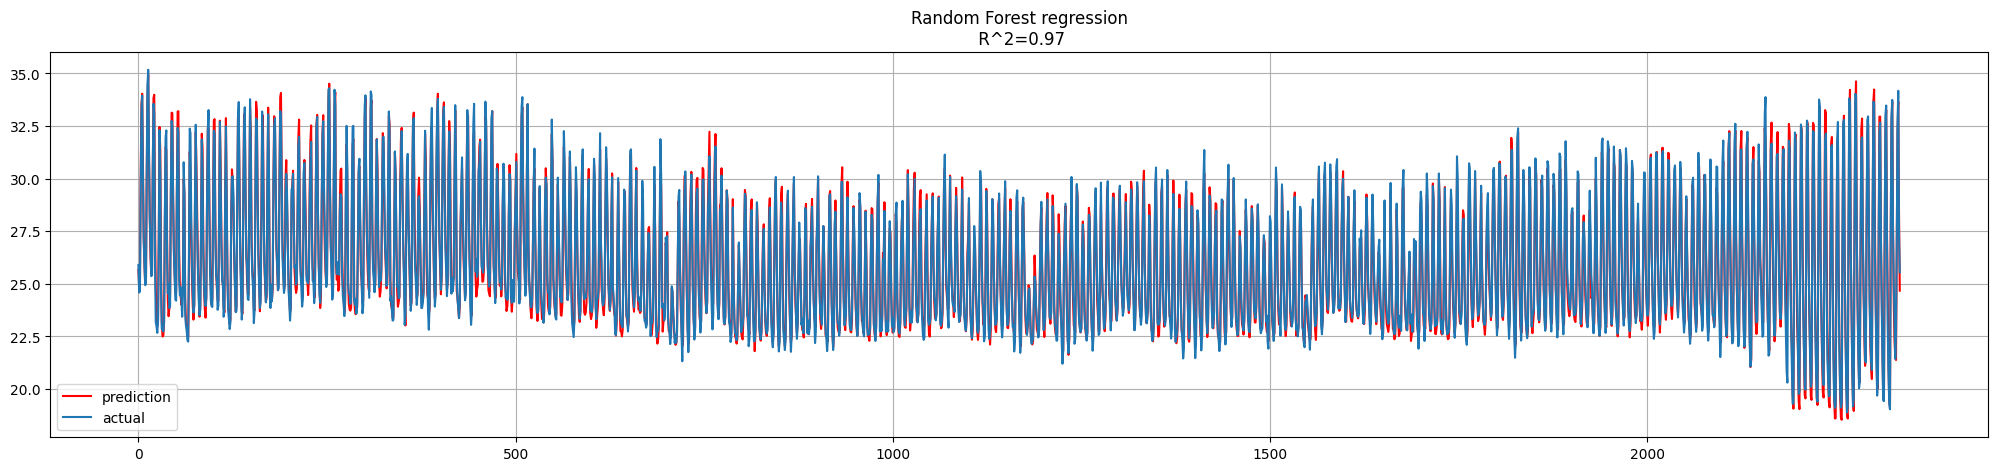

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = preprocess_data(test1, lag_end=12)

rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

plt.figure(figsize=(25, 5))
plt.plot(y_pred, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Random Forest regression\n R^2={r2_score(y_test, y_pred):.2f}");

In [ ]:
#############################################

**Effectuez l’analyse des résidus et documentez les résultats**

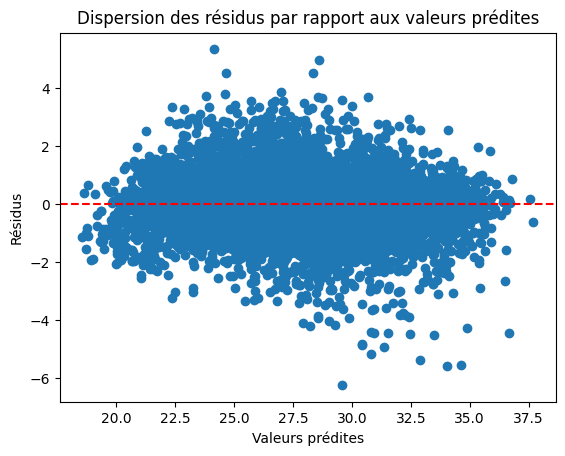

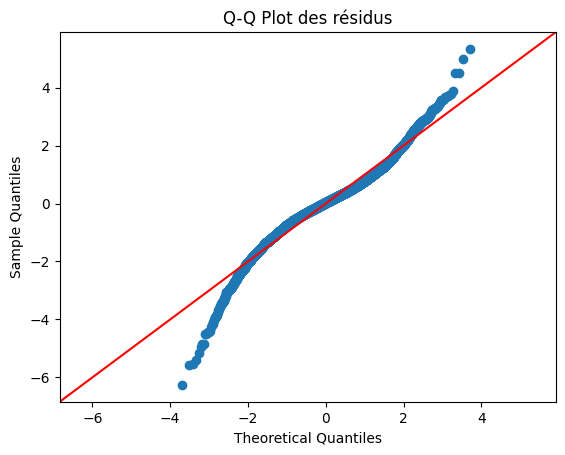

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Fit du modèle linéaire et calcul des résidus
model = sm.OLS(y_train, X_train)
results = model.fit()
residuals = results.resid

# Visualisation des résidus par rapport aux valeurs prédites
plt.scatter(results.fittedvalues, residuals)
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Dispersion des résidus par rapport aux valeurs prédites")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Graphique de densité des résidus
sm.qqplot(residuals, line ='45')
plt.title("Q-Q Plot des résidus")
plt.show()

# Autres analyses spécifiques selon les besoins
# Par exemple, tester l'homoscédasticité ou l'autocorrélation des résidus
